In [1]:
import numpy as np
import copy
import numpy.random as npr
import matplotlib.pyplot as plt
from numpy import newaxis as na
import utils
import conditionals as samp
from tqdm import tqdm
npr.seed(0)
%matplotlib inline

In [2]:
dim = 2
dim_y = 2
neurons = 100
nu = dim + 1
K = 4
depth = 3
"""
Parameters of generative model
"""
depth=3
scale=0.6
dim=2
Q=0.001*np.eye(dim)

"""
Hyper-planes
"""
R_par=np.zeros((dim + 1,1))
R_par[0,0]=100
R_par[1,0]=100
r_par=np.array([0.0])

R=[]
R.append(copy.deepcopy(R_par))
R_temp=np.zeros((dim + 1,2))
R_temp[:-1,0]=np.array([-100, 100]) #Left hyperplane
R_temp[:-1,1]=np.array([-100, 100]) #Right hyperplane
R.append(copy.deepcopy(R_temp))


"""
Emission parameters
"""
C=np.eye(dim)
C[0, 1] = 2
S=0.005*np.eye(dim)

"""
Dynamic Parameters
"""
A = np.zeros((dim, dim + 1, K))

#layer 2
theta_1 = -.15*np.pi/2
theta_2 = -.05*np.pi/2

A[:, :-1, 0] = np.eye(dim)
A[:, -1, 0] = np.array( [.25, 0] )

A[:, :-1, 1] = np.array( [ [ np.cos( theta_1 ), -np.sin( theta_1 ) ], [ np.sin( theta_1 ), np.cos( theta_1 ) ] ] )
A[:, -1, 1] = ((A[:, :-1, 1] + np.eye(dim) ) @ np.array ( [-4, 0] )[:, na]).flatten()

A[:, :-1, 2] = np.array( [ [ np.cos( theta_2 ), -np.sin( theta_2 ) ], [ np.sin( theta_2 ), np.cos( theta_2 ) ] ] )
A[:, -1, 2] = ((A[:, :-1, 2] + np.eye(dim) ) @ np.array ( [4, 0] )[:, na]).flatten()


A[:, :-1, 3] = np.eye( dim )
A[:, -1, 3] = np.array( [-.05, 0] )



possible_paths=np.ones((depth,K))
for d in range(1,depth):
    temp=np.arange(0,2**int(d))+1
    possible_paths[d,:]=np.repeat(temp,int(K/temp.size))

In [3]:
#Generate data
no_realizations = 200
Tmax = 800
Tmin = 600

X = []
Y = []
paths = []
Z = []

starting_pts = np.random.uniform(-15, 15, (dim, no_realizations) ) 
for n in tqdm(range(no_realizations)):
    T = npr.randint(Tmin, Tmax + 1)
    #Will be used to keep track of the path at every time instant
    path=np.ones( (depth, T+1) )
    #Generate data
    x = np.zeros((dim,T+1))
    x[:,0] = starting_pts[:, n]
    y = np.zeros((dim,T))
    z = K * np.ones(T + 1)
    for t in range(T):
        #First decide what path you will take
        log_prior_prob=np.zeros((K,1))
        for d in range(0,depth-1):
            temp=np.zeros((int(2**(d+1)),1)) #Make an array whose length is equal to the number hyperplanes at that level of the tree
            counter=0
            for j in range(0,int(2**d)):
                v = np.matmul(R[d][:-1, j], x[:, t]) + R[d][-1, j]
                temp[counter]=np.log(utils.sigmoid(v))
                temp[counter+1]=np.log(utils.sigmoid(-v))
                counter+=2
            log_prior_prob=log_prior_prob+np.repeat(temp,int(K/temp.size),axis=0)
        p_norm=np.exp(log_prior_prob)
        
        #Sample which path we will take
        choice = np.random.multinomial(1,p_norm.ravel(),size=1)
        path[:, t] =  possible_paths[:, np.where(choice==1)[1][0]].ravel()
        z[t] = np.where(choice[0, :] == 1)[0][0]
        
        #Simulate forward
        x[:, t + 1] = (A[:, :-1, int(z[t])] @ x[:, t][:, na] + A[:, -1, int(z[t])][:, na] 
                    + np.random.multivariate_normal( [0,0], Q )[:, na]).flatten()
        y[:, t] = (C @ x[:, t + 1][:, na] + np.random.multivariate_normal( [0,0], S )[:, na]).flatten()
    
    log_prior_prob=np.zeros((K,1))
    for d in range(0,depth-1):
        temp=np.zeros((int(2**(d+1)),1)) #Make an array whose length is equal to the number hyperplanes at that level of the tree
        counter=0
        for j in range(0,int(2**d)):
            v = np.matmul(R[d][:-1, j], x[:, T]) + R[d][-1, j]
            temp[counter]=np.log(utils.sigmoid(v))
            temp[counter+1]=np.log(utils.sigmoid(-v))
            counter+=2
        log_prior_prob=log_prior_prob+np.repeat(temp,int(K/temp.size),axis=0)
    p_norm=np.exp(log_prior_prob)
    
    #Sample which path we will take
    choice = np.random.multinomial(1,p_norm.ravel(),size=1)
    path[:, T] =  possible_paths[:, np.where(choice==1)[1][0]].ravel()
    z[T] = np.where(choice[0, :] == 1)[0][0]

    X.append(x)
    Y.append(y)
    paths.append(path)
    Z.append(z)
#     X.append(copy.copy(x))
#     Y.append(copy.copy(y))
#     paths.append(copy.copy(path))
#     Z.append(copy.copy(z))

100%|██████████| 200/200 [00:55<00:00,  3.58it/s]


100%|██████████| 200/200 [00:01<00:00, 116.22it/s]


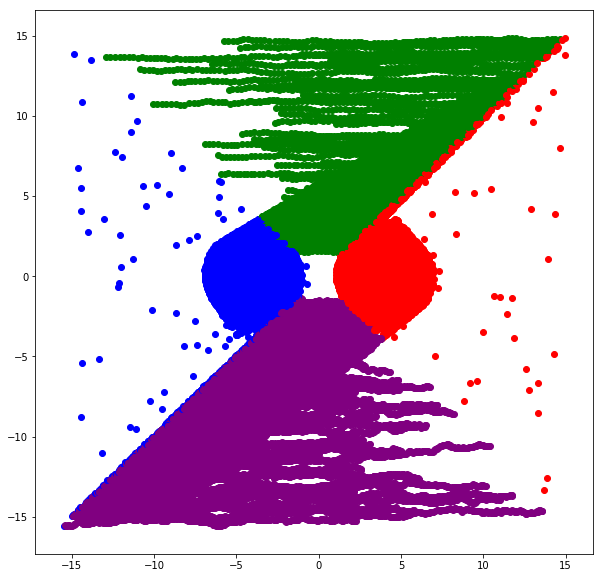

In [4]:
"Plot data"
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for idx in tqdm(range(no_realizations)):
    ax.scatter(X[idx][0, np.where(Z[idx]==0)], X[idx][1, np.where(Z[idx]==0)], color='green')
    ax.scatter(X[idx][0, np.where(Z[idx]==1)], X[idx][1, np.where(Z[idx]==1)], color='red')
    ax.scatter(X[idx][0, np.where(Z[idx]==2)], X[idx][1, np.where(Z[idx]==2)], color='blue')
    ax.scatter(X[idx][0, np.where(Z[idx]==3)], X[idx][1, np.where(Z[idx]==3)], color='purple')

# Start Testing Code

In [5]:
"Define hyperparameters used in sampling"
#Emission
My = np.zeros((dim_y, dim + 1))
nuy = dim_y + 1
lambday = 1e-7 * np.eye(dim_y)
Vy = 1000 * np.eye(dim + 1)

#Dynamics
Mx = np.zeros((dim, dim + 1))
nux = dim + 1
lambdax = dim + 1
Vx = 1000 * np.eye(dim + 1)

#Hyperplanes
mu = np.zeros(dim + 1)
Sigma = 1000 * np.eye(dim + 1)

#boolean mask
mask = [np.ones(X[idx][0, :].size).astype(bool) for idx in range(no_realizations)]

## Testing emission conditional distribution

In [6]:
C_samples = []
S_samples = []
no_samples = 1000
for m in tqdm(range(no_samples)):
    Csamp, Ssamp = samp.emission_parameters(Y, X, mask, nuy, lambday, My, Vy, normalize=False)

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: data type not understood